<a href="https://colab.research.google.com/github/okhko/Analysis_churn/blob/main/Analysis_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз оттока клиентов «Бета-Банка»

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Построим модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до `0.59`. Проверим F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Чек-лист работы над проектом

1. Загрузить и подготовьте данные. 
 - Пояснить порядок действий.
2. Исследовать баланс классов, обучить модель без учёта дисбаланса. 
 - Кратко описать выводы.
3. Улучшить качество модели, учитывая дисбаланс классов. 
 - Обучить разные модели и найдти лучшую. 
 - Кратко описать выводы.
4. Провести финальное тестирование.

### Описание данных

Данные находятся в файле [/datasets/Churn.csv](https://code.s3.yandex.net/datasets/Churn.csv) (англ. «отток клиентов»).

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак
- `Exited` — факт ухода клиента


## Настрйоки рабочей среды - установка библиотек и компонентов для работы

Импортируем библиотеки необходимы для нашей работы:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## Подготовка данных

Откроем наши DataFrame и результат выведем на экран. Таблицу `Churn` мы сохраним в `df`:

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Посмотрим на общуюю информацию:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В данном датасете 13 признако, целевой признак, 10000 строк.

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак
- `Exited` — факт ухода клиента

### Вывод:

В данных присутствуют столбцы, которые не нужны. Их можно удалить. В анализе они не нужны. Также есть пропуски в значении недвижимости. Это означает, что у клиента нет ее. Значит можно просто заменить 0 и перевести в целочисленный тип.



Удалим лишние столбцы:

In [ ]:
del_col=['RowNumber','EstimatedSalary','CustomerId','Surname']
df=df.drop(del_col,axis=1)

Заполним пропуски нулями:

In [ ]:
df['Tenure']=df['Tenure'].fillna(0).astype('int64')

Посмотрим, что у нас получилось:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     10000 non-null  int64  
 1   Geography       10000 non-null  object 
 2   Gender          10000 non-null  object 
 3   Age             10000 non-null  int64  
 4   Tenure          10000 non-null  int64  
 5   Balance         10000 non-null  float64
 6   NumOfProducts   10000 non-null  int64  
 7   HasCrCard       10000 non-null  int64  
 8   IsActiveMember  10000 non-null  int64  
 9   Exited          10000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


In [ ]:
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,619,France,Female,42,2,0.00,1,1,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,0
2,502,France,Female,42,8,159660.80,3,1,0,1
3,699,France,Female,39,1,0.00,2,0,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,0
5,645,Spain,Male,44,8,113755.78,2,1,0,1
6,822,France,Male,50,7,0.00,2,1,1,0
7,376,Germany,Female,29,4,115046.74,4,1,0,1
8,501,France,Male,44,4,142051.07,2,0,1,0
9,684,France,Male,27,2,134603.88,1,1,1,0


## Исследование задачи

Посмотрим на гистограмму значений оттока и оставшихся клиентов:

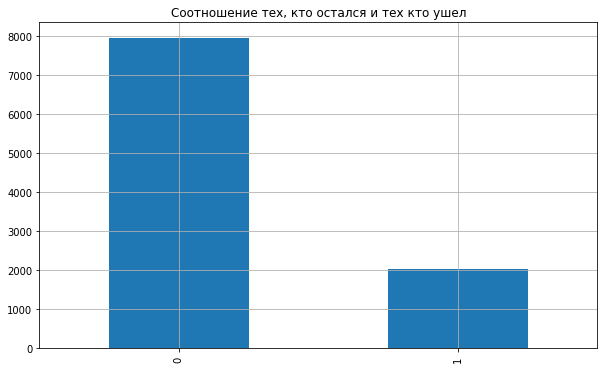

In [ ]:
df['Exited'].value_counts().plot(kind='bar',grid=True,figsize=(10,6),title='Соотношение тех, кто остался и тех кто ушел')

Соотношение оттока и тех кто остался 1:4. 

Вывод: такое соотношение говорит, что присутствует дисбаланс в данных.

Посмотрим как зависит возраст и отток клиентов: 

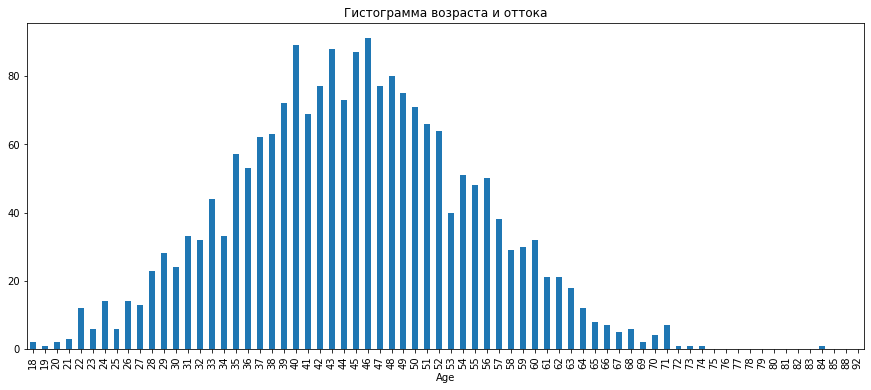

In [ ]:
df.groupby('Age')['Exited'].sum().plot(figsize=(15,6),kind='bar',title='Гистограмма возраста и оттока')
plt.show()

По гистограмме распределения видно, что отток зависит от возраста и распределено нормально. Больше всего уходит клиентов в возрасте от 40 до 50 лет. Посмотрим как зависит наличие недвижимости и отток клиентов: 

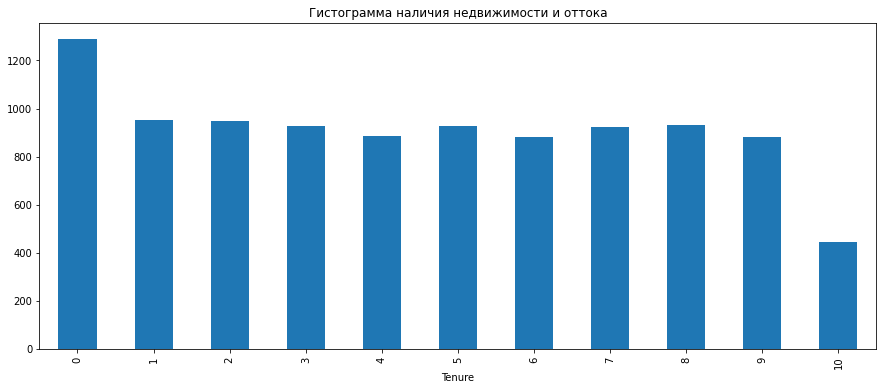

In [ ]:
df.groupby('Tenure')['Exited'].count().plot(figsize=(15,6),kind='bar',title='Гистограмма наличия недвижимости и оттока')
plt.show()

На этой гисторгамме видна не очень сильная зависимость, но можно увидеть, что те у кого нет недвижимости уходят чаще. Построем еще одну гистограмму, посмотрим медиану баланса денег у тех кто ушел и тех кто остался:

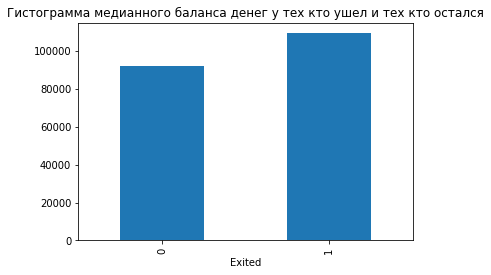

In [ ]:
df.groupby('Exited')['Balance'].median().plot(kind
                                              ='bar',title
                                              ='Гистограмма медианного баланса денег у тех кто ушел и тех кто остался')

На гистограмме видно, что зависимость не сильная, но среднее значение баланса немного выше у тех кто ушел. Посчитаем корреляцию Пирсона:

In [ ]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
CreditScore,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.027094
Age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,0.285323
Tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,-0.013319
Balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.118533
NumOfProducts,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,-0.047820
HasCrCard,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.007138
IsActiveMember,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.156128
Exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,1.000000


Видно, что все признаки не сильно коррелируются с целевым признаком. Скорее всего там зависимость сложнее.

### One hot encoder

Избавляемся от категориальных признаков методом One hot encoder. Вызываем метод get_dummies для избавления от категориальных признаков:

In [ ]:
df_ohe=pd.get_dummies(df,drop_first=True)

Целевой признак:

In [ ]:
target=df_ohe['Exited']

Признаки:

In [ ]:
features=df_ohe.drop(['Exited'],axis=1)

С помощью `train_test_split` разделим наш датасет на следующие выборки: 

In [ ]:
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

features_temp, test_features, target_temp, test_target = train_test_split(features, target, test_size=0.2, random_state=12345)
train_features, valid_features, train_target, valid_target = train_test_split(features_temp, target_temp, test_size=0.25, random_state=12345)

Стандартизируем тестовую и валидную выборку, т.к есть значения и маленькие и очень большие. 

In [ ]:
numeric=['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember']
scaler=StandardScaler()
scaler.fit(train_features[numeric])
train_features[numeric]=scaler.transform(train_features[numeric])
valid_features[numeric]=scaler.transform(valid_features[numeric])
test_features[numeric]=scaler.transform(test_features[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

### Ordinal Encoder

Метод Original encoder не принес хорошего результат, закоментируем его, чтобы не мешал в работе.

<div class="alert alert-block alert-info">
    
<b>Совет:</b><br> 1) Только ordinal - порядковый, а не оригинальный =) <br> 2) Для warning-а:  `pd.options.mode.chained_assignment = None` <br> 3) В нем нет необходимости после OHE
</div>

### Построим модель без учета баланса

#### Обучение с помощью модели Дерево решения

Поищем циклом ищем лучший гиперпораметр max_depth:

In [ ]:
for depth in range(1,10,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=1234).fit(train_features,train_target)
    prediction=model_tree.predict(valid_features)
    print('max_depth:',depth,'F1:',f1_score(valid_target,prediction))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.5037037037037037
max_depth: 3 F1: 0.39382239382239387
max_depth: 4 F1: 0.43902439024390244
max_depth: 5 F1: 0.5488372093023256
max_depth: 6 F1: 0.5104166666666666
max_depth: 7 F1: 0.5537974683544303
max_depth: 8 F1: 0.553125
max_depth: 9 F1: 0.5407066052227342


Вывод: лучшее значение max_depth=7, при котором F1=0,5537

#### Обучение с помощью модели Случайный лес

Поищем циклом ищем лучший гиперпораметр max_depth:

In [ ]:
for max_depth in range(1,20,1):
    model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=50,random_state=1234).fit(train_features,train_target)
    prediction=model_forest.predict(valid_features)
    print('max_depth:',max_depth,'F1:',f1_score(valid_target,prediction))

max_depth: 1 F1: 0.02525252525252525
max_depth: 2 F1: 0.21315192743764172
max_depth: 3 F1: 0.3443983402489626
max_depth: 4 F1: 0.36799999999999994
max_depth: 5 F1: 0.41904761904761906
max_depth: 6 F1: 0.5189003436426117
max_depth: 7 F1: 0.5293132328308208
max_depth: 8 F1: 0.541871921182266
max_depth: 9 F1: 0.5469522240527182
max_depth: 10 F1: 0.5508196721311475
max_depth: 11 F1: 0.5668789808917197
max_depth: 12 F1: 0.5700636942675159
max_depth: 13 F1: 0.5615141955835963
max_depth: 14 F1: 0.5718701700154559
max_depth: 15 F1: 0.5749613601236476
max_depth: 16 F1: 0.5714285714285714
max_depth: 17 F1: 0.562596599690881
max_depth: 18 F1: 0.5604900459418071
max_depth: 19 F1: 0.588597842835131


Вывод: лучшее значение max_depth=19, при котором F1=0,588

Циклом подбирем гиперпораметр n_estimators (количество деревьев)

In [ ]:
for estim in range(1,50,2):
    model_forest=RandomForestClassifier(max_depth=19,n_estimators=estim,random_state=1234).fit(train_features,train_target)
    prediction=model_forest.predict(valid_features)
    print('estim',estim,'F1:',f1_score(valid_target,prediction))

estim 1 F1: 0.4698646986469865
estim 3 F1: 0.5396383866481224
estim 5 F1: 0.5426136363636364
estim 7 F1: 0.5701624815361891
estim 9 F1: 0.5641025641025642
estim 11 F1: 0.5652841781874041
estim 13 F1: 0.5701078582434516
estim 15 F1: 0.5660964230171073
estim 17 F1: 0.564742589703588
estim 19 F1: 0.5807453416149068
estim 21 F1: 0.5763239875389408
estim 23 F1: 0.5842349304482226
estim 25 F1: 0.5784615384615385
estim 27 F1: 0.588957055214724
estim 29 F1: 0.5855161787365177
estim 31 F1: 0.5898617511520738
estim 33 F1: 0.5954198473282444
estim 35 F1: 0.5941807044410413
estim 37 F1: 0.5902140672782875
estim 39 F1: 0.5871559633027523
estim 41 F1: 0.5853658536585367
estim 43 F1: 0.5784615384615385
estim 45 F1: 0.588597842835131
estim 47 F1: 0.5862595419847328
estim 49 F1: 0.5887708649468892


Вывод: лучшее значение max_depth=19 и n_estimators=31 при котором F1=0,5898. Стало лучше.

#### Обучение с помощью модели Логистической регрессии

In [ ]:
model_logistic=LogisticRegression().fit(train_features,train_target)
prediction=model_logistic.predict(valid_features)
print('F1:',f1_score(valid_target,prediction))

F1: 0.30393996247654786


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Вывод: F1=0.3039

## Общий вывод: 

Рассматривая данные с дисбалансом (но, с переведенные категориальные и стандартизированные данные) тремя моделями можно сделать вывод, что саммая лучшая модель оказалась случайный лес. При лучшем значении max_depth=19, мы имеем F1 меру =0,5898 на тестовой(валидной) выборке.

Рисуем ROC  для логистической регрессии

In [ ]:
probabilities_tree=model_tree.predict_proba(valid_features)
probabilities_one_valid_tree=probabilities_tree[:,1]
fpr_tree,tpr_tree,thresholds=roc_curve(valid_target,probabilities_one_valid_tree)

In [ ]:
auc_roc_tree=roc_auc_score(valid_target,probabilities_one_valid_tree)

In [ ]:
auc_roc_tree

0.7823750355656083

In [ ]:
probabilities_forest=model_forest.predict_proba(valid_features)
probabilities_one_valid_forest=probabilities_forest[:,1]
fpr_forest,tpr_forest,thresholds=roc_curve(valid_target,probabilities_one_valid_forest)

In [ ]:
auc_roc_forest=roc_auc_score(valid_target,probabilities_one_valid_forest)

In [ ]:
auc_roc_forest

0.8375243793304604

In [ ]:
probabilities_reg=model_logistic.predict_proba(valid_features)
probabilities_one_valid_reg=probabilities_reg[:,1]
fpr_log,tpr_log,thresholds=roc_curve(valid_target,probabilities_one_valid_reg)

In [ ]:
auc_roc_reg=roc_auc_score(valid_target,probabilities_one_valid_reg)

In [ ]:
auc_roc_reg

0.7711132552029106

<Figure size 432x288 with 0 Axes>

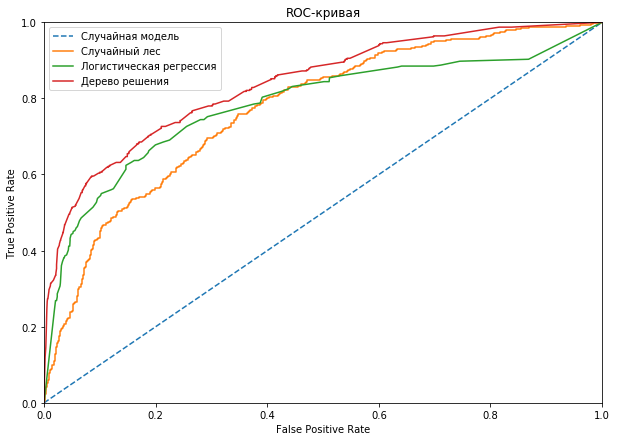

In [ ]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес','Логистическая регрессия','Дерево решения'),
           loc= 'upper left') 
plt.show()

## Борьба с дисбалансом

### Воспользуемся функцией Upsampling и увеличим количество клиентов оттока(target==1)

In [ ]:
def upsampling (features,target,repeat):
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    upsampling_features=pd.concat([features_null]+[features_one]*repeat)
    upsampling_target=pd.concat([target_null]+[target_one]*repeat)
    
    upsampling_features,upsampling_target=shuffle(upsampling_features,upsampling_target,random_state=1234)
    
    return upsampling_features,upsampling_target

In [ ]:
features_balance_up,target_balance_up=upsampling(train_features,train_target,4)

### Воспользуемся функцией Downsampling и увеличим количество клиентов оттока(target==1)

In [ ]:
def downsampling(features,target,fraction):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    downsampling_features=pd.concat([features_null.sample(frac=0.4,random_state=1234)]+[features_one])
    downsampling_target=pd.concat([target_null.sample(frac=0.4,random_state=1234)]+[target_one])
    
    downsampling_features,downsampling_target=shuffle(downsampling_features,downsampling_target,random_state=1234)
    return downsampling_features,downsampling_target

In [ ]:
#рев.1 - условно удален
#features_balance_up,target_balance_up=downsampling(features,target,0.4)

## Тестирование модели

## После балансирования данных. Обучение с помощью модели Дерево решения

Циклом ищем лучший гиперпораметр max_depth

In [ ]:
%%time

for depth in range(1,20,1):
    model_tree=DecisionTreeClassifier(class_weight='balanced',max_depth=depth,random_state=1234).fit(features_balance_up,target_balance_up)
  
    prediction=model_tree.predict(valid_features)
    print('max_depth:',depth,'F1:',f1_score(valid_target,prediction))

max_depth: 1 F1: 0.4750733137829912
max_depth: 2 F1: 0.49761677788369874
max_depth: 3 F1: 0.49761677788369874
max_depth: 4 F1: 0.5159474671669794
max_depth: 5 F1: 0.5487228003784296
max_depth: 6 F1: 0.5628140703517587
max_depth: 7 F1: 0.5603271983640081
max_depth: 8 F1: 0.5471698113207547
max_depth: 9 F1: 0.5179282868525896
max_depth: 10 F1: 0.5138178096212896
max_depth: 11 F1: 0.5042016806722689
max_depth: 12 F1: 0.49891540130151846
max_depth: 13 F1: 0.4901734104046243
max_depth: 14 F1: 0.48711943793911006
max_depth: 15 F1: 0.48560700876095114
max_depth: 16 F1: 0.48040455120101133
max_depth: 17 F1: 0.47692307692307695
max_depth: 18 F1: 0.484375
max_depth: 19 F1: 0.46675358539765316
CPU times: user 665 ms, sys: 4.2 ms, total: 669 ms
Wall time: 673 ms


## После балансирования данных. Обучение с помощью модели Случайный лес

Циклом ищем лучший гиперпораметр max_depth

In [ ]:
%%time

for max_depth in range(1,20,1):
    model_forest=RandomForestClassifier(class_weight='balanced',max_depth=max_depth,n_estimators=50,random_state=1234).fit(features_balance_up,target_balance_up)
    prediction=model_forest.predict(valid_features)
    print('max_depth:',max_depth,'F1:',f1_score(valid_target,prediction))

max_depth: 1 F1: 0.4990512333965844
max_depth: 2 F1: 0.527027027027027
max_depth: 3 F1: 0.5463709677419355
max_depth: 4 F1: 0.5461928934010153
max_depth: 5 F1: 0.5595854922279793
max_depth: 6 F1: 0.5666666666666667
max_depth: 7 F1: 0.5798319327731093
max_depth: 8 F1: 0.5845824411134904
max_depth: 9 F1: 0.5868131868131868
max_depth: 10 F1: 0.5921787709497207
max_depth: 11 F1: 0.5935334872979214
max_depth: 12 F1: 0.6011834319526628
max_depth: 13 F1: 0.5905707196029778
max_depth: 14 F1: 0.5950000000000001
max_depth: 15 F1: 0.5840938722294653
max_depth: 16 F1: 0.5989583333333334
max_depth: 17 F1: 0.5844504021447721
max_depth: 18 F1: 0.5804749340369394
max_depth: 19 F1: 0.5803814713896458
CPU times: user 9.32 s, sys: 51.3 ms, total: 9.37 s
Wall time: 10.1 s


Циклом подбираем гиперпораметр n_estimators (количество деревьев)

In [ ]:
%%time

for estim in range(1,51,1):
    model_forest=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=estim,random_state=1234).fit(features_balance_up,target_balance_up)
    prediction=model_forest.predict(valid_features)
    print('estim',estim,'F1:',f1_score(valid_target,prediction))
    

estim 1 F1: 0.4989816700610998
estim 2 F1: 0.5183537263626251
estim 3 F1: 0.5655021834061135
estim 4 F1: 0.5518814139110604
estim 5 F1: 0.5662100456621004
estim 6 F1: 0.5622857142857143
estim 7 F1: 0.563573883161512
estim 8 F1: 0.5687645687645687
estim 9 F1: 0.580046403712297
estim 10 F1: 0.5772727272727273
estim 11 F1: 0.5851428571428571
estim 12 F1: 0.5856980703745743
estim 13 F1: 0.5879682179341658
estim 14 F1: 0.5889145496535796
estim 15 F1: 0.6052934407364787
estim 16 F1: 0.5908045977011493
estim 17 F1: 0.5955967555040556
estim 18 F1: 0.5979142526071842
estim 19 F1: 0.5993031358885018
estim 20 F1: 0.5900116144018582
estim 21 F1: 0.5965317919075145
estim 22 F1: 0.5905420991926182
estim 23 F1: 0.5912240184757506
estim 24 F1: 0.5909617612977983
estim 25 F1: 0.5870069605568445
estim 26 F1: 0.5879629629629629
estim 27 F1: 0.5833333333333334
estim 28 F1: 0.5836216839677048
estim 29 F1: 0.5790080738177624
estim 30 F1: 0.5826589595375722
estim 31 F1: 0.581986143187067
estim 32 F1: 0.58034

In [ ]:
 model_forest=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=50,random_state=1234).fit(features_balance_up,target_balance_up)

## После балансирования данных. Обучение с помощью модели Логистической регрессии

In [ ]:
%%time

model_logistic=LogisticRegression(class_weight='balanced',solver='liblinear').fit(features_balance_up,target_balance_up)
prediction=model_logistic.predict(valid_features)
print('F1:',f1_score(valid_target,prediction))

F1: 0.4820788530465949
CPU times: user 30.1 ms, sys: 11.7 ms, total: 41.9 ms
Wall time: 32.2 ms


Вывод: Мера F1 поменялась. Стала гораздо лучше. F1=0.4820

## Исследование метрика AUC-ROC

Рисуем ROC  для логистической регрессии

In [ ]:
%%time

model_logistic=LogisticRegression(class_weight='balanced',solver='liblinear').fit(features_balance_up,target_balance_up)
prediction=model_logistic.predict(valid_features)
print('F1:',f1_score(prediction, valid_target))


F1: 0.4820788530465949
CPU times: user 53.4 ms, sys: 92 ms, total: 145 ms
Wall time: 194 ms


In [ ]:
probabilities_tree=model_tree.predict_proba(valid_features)
probabilities_one_valid_tree=probabilities_tree[:,1]
fpr_tree,tpr_tree,thresholds=roc_curve(valid_target,probabilities_one_valid_tree)

In [ ]:
auc_roc_tree=roc_auc_score(valid_target,probabilities_one_valid_tree)

In [ ]:
auc_roc_tree

0.6685905210302024

In [ ]:
probabilities_forest=model_forest.predict_proba(valid_features)
probabilities_one_valid_forest=probabilities_forest[:,1]
fpr_forest,tpr_forest,thresholds=roc_curve(valid_target,probabilities_one_valid_forest)

In [ ]:
auc_roc_forest=roc_auc_score(valid_target,probabilities_one_valid_forest)

In [ ]:
auc_roc_forest

0.8501173863768221

In [ ]:
probabilities_reg=model_logistic.predict_proba(valid_features)
probabilities_one_valid_reg=probabilities_reg[:,1]
fpr_log,tpr_log,thresholds=roc_curve(valid_target,probabilities_one_valid_reg)

In [ ]:
auc_roc_reg=roc_auc_score(valid_target,probabilities_one_valid_reg)

In [ ]:
auc_roc_reg

0.7732797769579365

<Figure size 432x288 with 0 Axes>

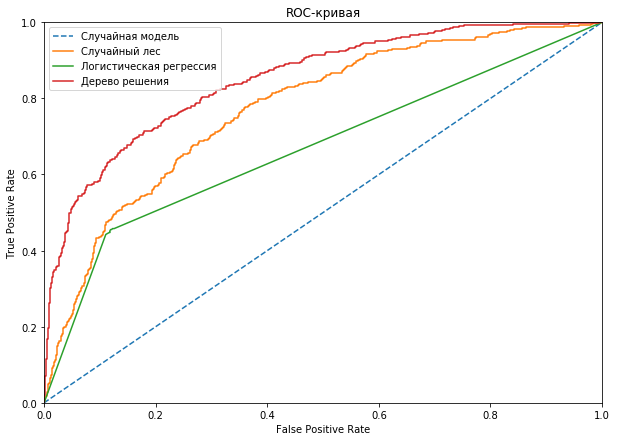

In [ ]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес','Логистическая регрессия','Дерево решения'),
           loc= 'upper left') 
plt.show()

Значение площади под кривой. На сколько наша модель отличается от случайной

Лучшее значение метрики auc roc=0.8501 у модели Случайный лес

## Общий вывод:

Проведем итоговое тестирование:

In [ ]:
prediction=model_forest.predict(test_features)
print('F1:',f1_score(test_target, prediction))

F1: 0.6393805309734514


In [ ]:
probabilities_forest=model_forest.predict_proba(test_features)
probabilities_one_test_forest=probabilities_forest[:,1]
fpr_forest,tpr_forest,thresholds=roc_curve(test_target,probabilities_one_test_forest)
print('ROC-AUC:', roc_auc_score(test_target,probabilities_one_test_forest))

ROC-AUC: 0.8601532595571343


In [ ]:
rezult1={'Дерево Решения':np.array([0.5537,0.582]),'Случайный лес':np.array([0.588,0.612]),'Логистическая регрессия':np.array([0.3039,0.478])}
rezult_df=pd.DataFrame(rezult1,index=['F1 без учета дисбаланса','F1 с учетом дисбаланса'])

In [ ]:
rezult_df

,Дерево Решения,Случайный лес,Логистическая регрессия
F1 без учета дисбаланса,0.5537,0.588,0.3039
F1 с учетом дисбаланса,0.5820,0.612,0.4780


Рассматривая данные с учетом дисбаланса + переведенные категориальные + стандартизированные данные и без учета дисбаланса тремя моделями можно сделать вывод, что самая лучшая модель оказалась Случайный лес. При лучшем значении max_depth=19, n_estimators=50, мы имеем F1 меру =0,588 на тестовой(валидной) выборке. Хуже всего себя показала модель Логистическая регрессия

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*